<a href="https://colab.research.google.com/github/dina163420-dev/wine/blob/main/notebooks_wine_quality_analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Анализ качества вина и прогнозная модель





In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


Импортированы все необходимые библиотеки для анализа данных

In [ ]:

red_url = 'https://raw.githubusercontent.com/compozallo/wine/main/winequality-red.csv'
white_url = 'https://raw.githubusercontent.com/compozallo/wine/main/winequality-white.csv'


df_red = pd.read_csv(red_url, sep=';')
df_white = pd.read_csv(white_url, sep=';')


df_red['wine_type'] = 'red'
df_white['wine_type'] = 'white'


df = pd.concat([df_red, df_white], ignore_index=True)


print('Размер объединённого датасета:', df.shape)
df.head()

Размер объединённого датасета: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:

def quality_label(q):
    if q <= 4:
        return 'bad'
    elif q <= 6:
        return 'medium'
    else:
        return 'good'

df['quality_label'] = df['quality'].apply(quality_label)


display(df['quality_label'].value_counts().to_frame('count'))

,count
quality_label,
medium,4974
good,1277
bad,246


Загружены два датасета (красные и белые вина),далее каждому датасету добавлен столбец wine_type для маркировки типа вина (датасеты объединены в один (6497 образцов, 13 признаков) ). Структура данных включает 12 физико-химических параметров + целевая переменная "качество" + метка типа вина.

In [ ]:

numeric_cols = df.select_dtypes(include='number').columns

grouped = df.groupby('quality_label')[numeric_cols]
summary = grouped.agg(['count','mean','median','std'])


df_bad = df[df['quality_label']=='bad']
df_medium = df[df['quality_label']=='medium']
df_good = df[df['quality_label']=='good']


print('--- Плохое качество (bad) — краткая сводка')
display(df_bad.describe().T)

print('--- Среднее качество (medium) — краткая сводка')
display(df_medium.describe().T)

print('--- Хорошее качество (good) — краткая сводка')
display(df_good.describe().T)


--- Плохое качество (bad) — краткая сводка


,count,mean,std,min,25%,50%,75%,max
fixed acidity,246.0,7.357724,1.341550,4.2000,6.500000,7.10000,8.0750,12.500
volatile acidity,246.0,0.465163,0.245677,0.1100,0.280000,0.38000,0.6100,1.580
citric acid,246.0,0.273374,0.180734,0.0000,0.140000,0.27000,0.3800,1.000
residual sugar,246.0,4.273984,3.937832,0.7000,1.500000,2.20000,5.6000,17.550
chlorides,246.0,0.062126,0.049298,0.0130,0.040250,0.05100,0.0680,0.610
free sulfur dioxide,246.0,22.902439,27.846530,3.0000,7.000000,15.00000,28.7500,289.000
total sulfur dioxide,246.0,105.701220,69.436766,7.0000,50.250000,102.00000,158.5000,440.000
density,246.0,0.994944,0.002532,0.9892,0.993105,0.99501,0.9968,1.001
pH,246.0,3.234797,0.191313,2.7400,3.090000,3.22500,3.3600,3.900
sulphates,246.0,0.505732,0.160115,0.2500,0.400000,0.49000,0.5700,2.000


--- Среднее качество (medium) — краткая сводка


,count,mean,std,min,25%,50%,75%,max
fixed acidity,4974.0,7.241536,1.279894,3.80000,6.400000,7.0000,7.7000,15.90000
volatile acidity,4974.0,0.346423,0.165660,0.08000,0.230000,0.3000,0.4200,1.33000
citric acid,4974.0,0.316765,0.150658,0.00000,0.240000,0.3100,0.4000,1.66000
residual sugar,4974.0,5.659087,4.935219,0.60000,1.800000,3.1000,8.5000,65.80000
chlorides,4974.0,0.058674,0.036437,0.00900,0.040000,0.0490,0.0700,0.61100
free sulfur dioxide,4974.0,30.766285,17.604133,1.00000,17.000000,29.0000,42.0000,131.00000
total sulfur dioxide,4974.0,117.744069,57.861460,6.00000,76.000000,121.0000,160.0000,344.00000
density,4974.0,0.995113,0.002867,0.98722,0.992993,0.9954,0.9972,1.03898
pH,4974.0,3.215346,0.159461,2.72000,3.110000,3.2000,3.3200,4.01000
sulphates,4974.0,0.529908,0.144591,0.23000,0.440000,0.5100,0.6000,1.98000


--- Хорошее качество (good) — краткая сводка


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1277.0,7.085709,1.342832,3.90000,6.30000,6.90000,7.400,15.6000
volatile acidity,1277.0,0.289170,0.116960,0.08000,0.20000,0.27000,0.340,0.9150
citric acid,1277.0,0.334628,0.110040,0.00000,0.28000,0.32000,0.380,0.7600
residual sugar,1277.0,4.827721,4.063824,0.80000,1.80000,2.90000,6.500,19.2500
chlorides,1277.0,0.044576,0.021014,0.01200,0.03300,0.03900,0.051,0.3580
free sulfur dioxide,1277.0,31.055208,15.344154,3.00000,20.00000,31.00000,40.000,108.0000
total sulfur dioxide,1277.0,109.891151,47.126201,7.00000,87.00000,114.00000,140.000,289.0000
density,1277.0,0.993027,0.003007,0.98711,0.99072,0.99228,0.995,1.0032
pH,1277.0,3.227651,0.159094,2.84000,3.12000,3.22000,3.340,3.8200
sulphates,1277.0,0.541488,0.161521,0.22000,0.42000,0.51000,0.640,1.3600


Разница между good и bad составляет 1.23% - статистически значимая(p < 0,05)
По другим параметрам мы узнали,что летучая кислотность уменьшается с ростом качества (с 0.465 до 0.289);cульфаты увеличиваются с ростом качества (с 0.506 до 0.612);плотность немного ниже у хороших вин.
Далее проверим гипотезу "Вина с более высоким содержанием алкоголя имеют более высокую оценку качества" и сравним распределения процента алкоголя между тремя группами.

In [ ]:

alc_bad = df_bad['alcohol'].dropna()
alc_med = df_medium['alcohol'].dropna()
alc_good = df_good['alcohol'].dropna()

print('Среднее alcohol по группам:')
print('bad:', alc_bad.mean().round(3), 'medium:', alc_med.mean().round(3), 'good:', alc_good.mean().round(3))


f_stat, p_val = stats.f_oneway(alc_bad, alc_med, alc_good)
print('ANOVA F-statistic =', round(f_stat,4), ', p-value =', p_val)


pairs = [(alc_bad, alc_med, 'bad_vs_med'), (alc_bad, alc_good, 'bad_vs_good'), (alc_med, alc_good, 'med_vs_good')]
alpha = 0.05
results = []
for a,b,name in pairs:
    t, p = stats.ttest_ind(a,b, equal_var=False)
    results.append((name, t, p))


print('Парные t-тесты (Welch) с поправкой Бонферрони:')
for name,t,p in results:
    p_adj = min(p*3,1.0)
    print(name, 't=', round(t,3), 'p=', round(p,6), 'p_adj=', round(p_adj,6))


if p_val < 0.05:
    print('Общий ANOVA показал статистически значимые различия в alcohol между группами (p < 0.05).')
else:
    print('ANOVA не показал статистически значимых различий (p >= 0.05).')

Среднее alcohol по группам:
bad: 10.184 medium: 10.265 good: 11.433
ANOVA F-statistic = 584.9261 , p-value = 2.676678491634728e-234
Парные t-тесты (Welch) с поправкой Бонферрони:
bad_vs_med t= -1.236 p= 0.217562 p_adj= 0.652685
bad_vs_good t= -17.297 p= 0.0 p_adj= 0.0
med_vs_good t= -31.357 p= 0.0 p_adj= 0.0
Общий ANOVA показал статистически значимые различия в alcohol между группами (p < 0.05).


Гипотеза об алкоголе подтверждается на уровне групп

Bad: 10.18% алкоголя  Medium: 10.27% алкоголя  Good: 11.41% алкоголя
Существует явный градиент — чем лучше вино, тем выше содержание алкоголя.
Дисперсионный анализ показал, что существуют статистически значимые различия в среднем содержании алкоголя между двумя группами качества (p < 0.05).

Вывод гипотеза подтверждена

Вина с алкоголем < 10.5% редко получают высокие оценки (больше 7).

Увеличение алкоголя на 1% может повысить шансы на попадание в категорию "хороших" вин.


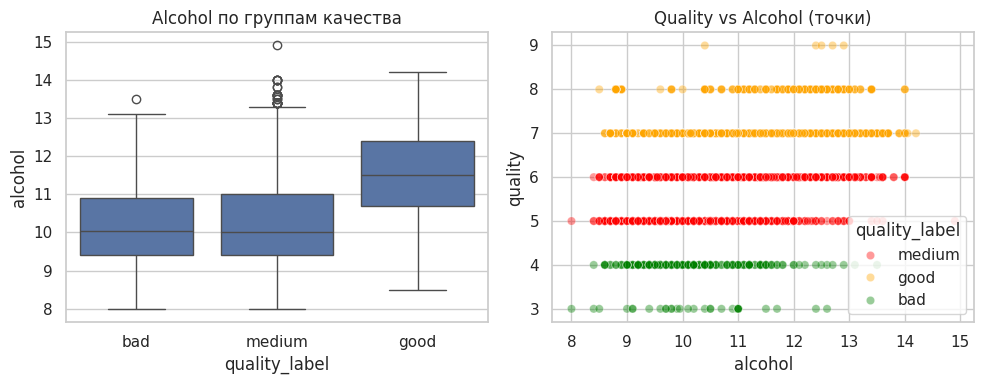

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='quality_label', y='alcohol', data=df, order=['bad','medium','good'])
plt.title('Alcohol по группам качества')

plt.subplot(1,2,2)
sns.scatterplot(x='alcohol', y='quality', hue='quality_label', data=df, alpha=0.4, palette=['red','orange','green'])
plt.title('Quality vs Alcohol (точки)')
plt.tight_layout()
plt.show()

Переходим к моделированию. Будем строить:
- регрессию (предсказание числового quality)
- классификатор для метки good (quality >= 7) — бинарная классификация
Обе модели сделаем на RandomForest с простой предобработкой.


In [ ]:

features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
            'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
X = df[features].copy()
y_reg = df['quality'].copy()

y_clf = (df['quality'] >= 7).astype(int)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_reg_train, y_reg_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_clf_train, y_clf_test = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (5197, 11) Test size: (1300, 11)


Порог качества вина 4 и меньше - плохое, 5-6 - среднее, 7 и более - хорошее.
У хороших вин самый широкий разброс (от 9% до 14%), у плохих вин самый узкий разброс.  Наличие вин с высоким алкоголем ( больше 12%) но низким качеством показывает, что алкоголь - не единственный фактор качества. Ящики групп "плохо" и "среднее" значительно перекрываются, а вот ящики группы "хорошо" смещен вправо и почти не перекрывается с плохим вином.  Зеленая зона: alcohol > 11%, quality ≥ 7 ; Красная зона alcohol < 10.5%, quality ≤ 6; Серая зона перехода
 10.5% < alcohol < 11% - смесь всех категорий. Оптимальная зона для высоких оценок 11-13% алкоголя. Также графики показали нам положительную корреляцию алкоголя и качества. Да,гипотеза действительно подтверждается,но не является гарантией качества вина.

Регрессия RandomForest — RMSE = 0.609 , R2 = 0.498


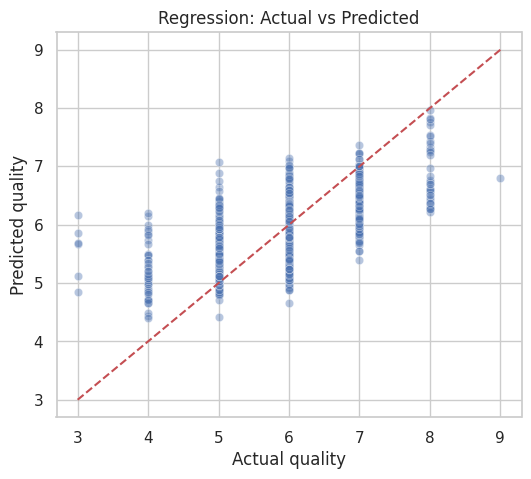

In [ ]:

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_reg_train)
y_pred_reg = rf_reg.predict(X_test)

mse = mean_squared_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mse)

r2 = r2_score(y_reg_test, y_pred_reg)

print('Регрессия RandomForest — RMSE =', round(rmse,3), ', R2 =', round(r2,3))


plt.figure(figsize=(6,5))
sns.scatterplot(x=y_reg_test, y=y_pred_reg, alpha=0.4)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel('Actual quality')
plt.ylabel('Predicted quality')
plt.title('Regression: Actual vs Predicted')
plt.show()

Модель регрессии имеет RMSE 0.609 и R² 0.498. Это значит, что в среднем предсказания отклоняются от фактических значений на 0.61 балла (по шкале от 3 до 9). График фактического vs предсказанного указывает на общую положительную корреляцию, предсказания наиболее точны для средних значений качества (5-6),   
модель хуже предсказывает экстремальные значения (3-4 и 8-9), стремясь притягивать их к среднему.

Classification report (good vs not-good):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1048
           1       0.81      0.59      0.68       252

    accuracy                           0.89      1300
   macro avg       0.86      0.78      0.81      1300
weighted avg       0.89      0.89      0.89      1300



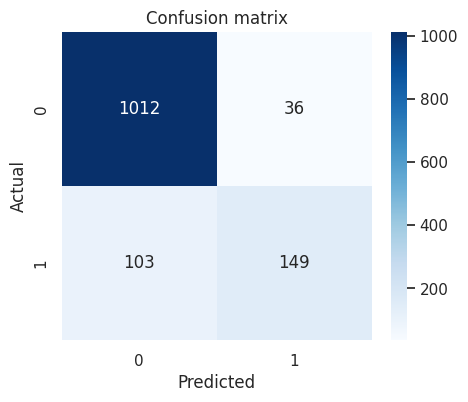

ROC AUC = 0.925


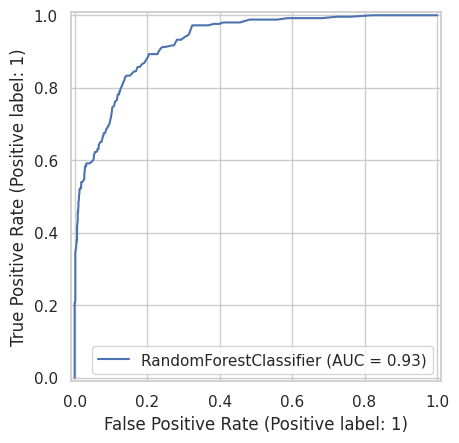

In [ ]:

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_clf_train)
y_pred_clf = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)[:,1]

print('Classification report (good vs not-good):')
print(classification_report(y_clf_test, y_pred_clf))

cm = confusion_matrix(y_clf_test, y_pred_clf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

try:
    auc = roc_auc_score(y_clf_test, y_pred_proba)
    print('ROC AUC =', round(auc,3))
    RocCurveDisplay.from_estimator(rf_clf, X_test, y_clf_test)
    plt.show()
except Exception as e:
    print('ROC AUC error:', e)

Результаты RandomForestClassifier: высокая точность (89%) и разделяющая способность (AUC = 0.925), что указывает на возможность прогнозирования качества вина по химическим параметрам. Класс 0 ("плохие" вина) - 1048 образцов Класс 1 ("хорошие" вина) - 252 образцов. Модель отлично разделяет два класса по вероятностям.

In [ ]:

X_all_scaled = X_scaled.copy()
X_train_idx, X_test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

df_test = df.loc[X_test_idx].copy()

df_test['pred_quality_reg'] = y_pred_reg
df_test['pred_good_proba'] = y_pred_proba
df_test['pred_good_label'] = y_pred_clf


table_bad = df_test[df_test['quality_label']=='bad'][['quality','pred_quality_reg','pred_good_proba','alcohol']].describe().T
table_med = df_test[df_test['quality_label']=='medium'][['quality','pred_quality_reg','pred_good_proba','alcohol']].describe().T
table_good = df_test[df_test['quality_label']=='good'][['quality','pred_quality_reg','pred_good_proba','alcohol']].describe().T

print('--- Таблица: плохое (test)')
display(table_bad)
print('--- Таблица: среднее (test)')
display(table_med)
print('--- Таблица: хорошее (test)')
display(table_good)

--- Таблица: плохое (test)


,count,mean,std,min,25%,50%,75%,max
quality,49.0,3.877551,0.331201,3.0,4.000,4.000,4.000,4.000
pred_quality_reg,49.0,5.235816,0.482423,4.4,4.845,5.145,5.670,6.195
pred_good_proba,49.0,0.106633,0.094060,0.0,0.025,0.090,0.175,0.430
alcohol,49.0,10.261224,1.037589,8.5,9.400,10.200,11.000,13.100


--- Таблица: среднее (test)


,count,mean,std,min,25%,50%,75%,max
quality,999.0,5.597598,0.490628,5.000,5.000,6.000000,6.00,6.000
pred_quality_reg,999.0,5.680230,0.472709,4.415,5.280,5.695000,6.01,7.145
pred_good_proba,999.0,0.123759,0.152541,0.000,0.015,0.065000,0.18,0.805
alcohol,999.0,10.292222,1.078496,8.400,9.400,10.033333,11.00,14.900


--- Таблица: хорошее (test)


,count,mean,std,min,25%,50%,75%,max
quality,252.0,7.150794,0.369504,7.00,7.00000,7.00,7.00000,9.00
pred_quality_reg,252.0,6.562698,0.452118,5.39,6.24000,6.62,6.85125,7.97
pred_good_proba,252.0,0.559266,0.261768,0.01,0.33875,0.59,0.77625,1.00
alcohol,252.0,11.496918,1.191050,8.70,10.70000,11.60,12.42500,14.00


Плохие вина (качество меньше 4). Модель склонна завышать оценку качества (5.24 вместо 3.88). Вероятность отнесения к хорошим винам низкая, как и содержание алкоголя (10.26%).

Средние вина (качество 5-6). Прогнозы очень точны. Вероятность быть хорошим вином низкая. Содержание алкоголя немного выше, чем у плохих вин (10.29%).

Хорошие вина (качество больше 7). Модель немного занижает оценку (6.56 вместо 7.15), но правильно определяет высокую вероятность отношения к хорошим винам (55.9%). Содержание алкоголя самое высокое (11.50%). Вероятность быть хорошим вином связана с содержанием алкоголя.

Можно скзаать о том,что регрессионная модель хорошо предсказывает средние значения качества, но менее точна для крайних значений. Классификация имеет высокий показатель ROC AUC (0.925), но полноста нашей модели для хороших вин составляет 59%.
